# Using Latte with Pytorch

This example notebook demonstrates the use of [Latte](https://github.com/karnwatcharasupat/latte) with vanilla [PyTorch](https://pytorch.org/) (without Lightning). 

The code in this notebook is adapted from the [AR-VAE](https://github.com/ashispati/ar-vae) implementation:
> A. Pati and A. Lerch, Attribute-based regularization of latent spaces for variational auto-encoders. Neural Computing & Applications, 33, 4429–4444 (2021). https://doi.org/10.1007/s00521-020-05270-2


For this notebook, we will be using the [Morpho-MNIST](https://github.com/dccastro/Morpho-MNIST) dataset which is a disentanglement dataset built on the usual MNIST dataset.

**Before you begin, please turn on GPU accelerator at `Runtime > Change runtime type > Hardware accelerator > GPU`.**

In [ ]:
HOME = '/content'

## Installing Latte and Dependencies

In [ ]:
# This command automatically install PyTorch and TorchMetrics.
# For users with existing pytorch>=1.3.1 and torchmetrics>=0.2.0 installation, 
#   use `pip install latte-metrics` with no extras
!pip install -q latte-metrics[pytorch]   

## Preparing data

### Downloading dataset

In [ ]:
%%bash

export DSET_PATH="/content/dataset" 
mkdir -p $DSET_PATH
gdown --id "1fFGJW0IHoBmLuD6CEKCB8jz3Y5LJ5Duk" -O $DSET_PATH/morphomnist.zip
unzip -o "$DSET_PATH/morphomnist.zip" -d $DSET_PATH

### Cloning Morpho-MNIST measurement code

In [ ]:
!git clone https://github.com/dccastro/Morpho-MNIST

In [ ]:
import os, sys
sys.path.append(os.path.join(HOME, 'Morpho-MNIST'))

In [5]:
# import os, sys
# sys.path.append(os.path.expanduser('~/Morpho-MNIST'))

### Creating dataloader

In [37]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from morphomnist import io, morpho

class MorphoMnistDataset():

    def __init__(self, root_dir=os.path.join(HOME, 'dataset/global')):
        super().__init__()
        self.kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
        self.root_dir = root_dir
        self.data_path_str = "-images-idx3-ubyte.gz"
        self.label_path_str = "-labels-idx1-ubyte.gz"
        self.morpho_path_str = "-morpho.csv"

        self.train_dataset = self._create_dataset(dataset_type="train")
        self.val_dataset = self._create_dataset(dataset_type="t10k")

    def data_loaders(self, batch_size, limit=None):
        
        train_dl = DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            shuffle=True,
            **self.kwargs
        )
        
        val_dl = DataLoader(
            self.val_dataset,
            batch_size=batch_size,
            shuffle=False,
        )
        return train_dl, val_dl

    def _create_dataset(self, dataset_type="train"):
        data_path = os.path.join(
            self.root_dir,
            dataset_type + self.data_path_str
        )
        morpho_path = os.path.join(
            self.root_dir,
            dataset_type + self.morpho_path_str
        )
        images = io.load_idx(data_path)
        images = np.expand_dims(images, axis=1).astype('float32') / 255.0
        morpho_labels = pd.read_csv(morpho_path).values.astype('float32')[:, 3:]
        dataset = TensorDataset(
            torch.from_numpy(images),
            torch.from_numpy(morpho_labels)
        )
        return dataset

## Creating a simple AR-VAE

### Defining the Loss Function

In [7]:
from torch.nn import functional as F

def ar_signed_loss(z, a, factor=10.0):

    n_attr = a.shape[-1]

    # compute latent distance matrix
    lc_dist_mat = z[:, None, :n_attr] - z[None, :, :n_attr]

    # compute attribute distance matrix
    attribute_dist_mat = a[:, None, ...] - a[None, :, :]

    # compute regularization loss
    lc_tanh = torch.tanh(lc_dist_mat * factor)
    attribute_sign = torch.sign(attribute_dist_mat)
    batch_size = z.shape[0]
    ar_loss = F.l1_loss(lc_tanh, attribute_sign.float(), reduction='sum')/(batch_size ** 2 - batch_size)

    return ar_loss

def compute_loss(x, xhat, zd, z0, z, a, beta=1.0, gamma=1.0):

    recon_loss = F.mse_loss(x, torch.sigmoid(xhat), reduction='sum')/z.shape[0]

    kld_loss = distributions.kl.kl_divergence(zd, z0).sum(-1).mean()

    ar_loss = ar_signed_loss(z, a)

    return {
        'loss': recon_loss + beta * kld_loss + gamma * ar_loss,
        'recon_loss': recon_loss,
        'kld_loss': kld_loss,
        'ar_loss': ar_loss
    }

### Defining base VAE class

In [46]:
from torch import nn, distributions

class ImageVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 784
        self.z_dim = 16
        self.inter_dim = 19
        self.enc_conv = nn.Sequential(
            nn.Conv2d(1, 64, 4, 1),
            nn.SELU(),
            nn.Dropout(0.5),
            nn.Conv2d(64, 64, 4, 1),
            nn.SELU(),
            nn.Dropout(0.5),
            nn.Conv2d(64, 8, 4, 1),
            nn.SELU(),
            nn.Dropout(0.5),
        )
        self.enc_lin = nn.Sequential(
            nn.Linear(2888, 256),
            nn.SELU()
        )
        self.enc_mean = nn.Linear(256, self.z_dim)
        self.enc_log_std = nn.Linear(256, self.z_dim)
        self.dec_lin = nn.Sequential(
            nn.Linear(self.z_dim, 256),
            nn.SELU(),
            nn.Linear(256, 2888),
            nn.SELU()
        )
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(8, 64, 4, 1),
            nn.SELU(),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(64, 64, 4, 1),
            nn.SELU(),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(64, 1, 4, 1),
        )

        self.xavier_initialization()

    def xavier_initialization(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)

    def encode(self, x):
        hidden = self.enc_conv(x)
        hidden = hidden.view(x.size(0), -1)
        hidden = self.enc_lin(hidden)
        z_mean = self.enc_mean(hidden)
        z_log_std = self.enc_log_std(hidden)
        z_distribution = distributions.Normal(loc=z_mean, scale=torch.exp(z_log_std) + 1e-16)
        return z_distribution

    def decode(self, z):
        hidden = self.dec_lin(z)
        hidden = hidden.view(z.size(0), -1, self.inter_dim, self.inter_dim)
        hidden = self.dec_conv(hidden)
        return hidden

    def reparametrize(self, z_dist):
        # sample from distribution
        z_tilde = z_dist.rsample()

        # compute prior
        prior_dist = torch.distributions.Normal(
            loc=torch.zeros_like(z_dist.loc),
            scale=torch.ones_like(z_dist.scale)
        )
        return z_tilde, prior_dist

    def forward(self, x):
        # compute distribution using encoder
        z_dist = self.encode(x)

        # reparametrize
        z_tilde, prior_dist = self.reparametrize(z_dist)

        # compute output of decoding layer
        output = self.decode(z_tilde).view(x.size())

        return output, z_dist, prior_dist, z_tilde
    
    def interpolate(self, x, dz):
        # compute distribution using encoder
        z_dist = self.encode(x)

        # reparametrize
        z_tilde, prior_dist = self.reparametrize(z_dist)

        # compute output of decoding layer
        if dz.ndim > 1:
            output = []
            for i in range(dz.shape[-1]):
                output.append(self.decode(z_tilde + dz[None, :, i]).view(x.size()))
            output = torch.stack(output, axis=-1)
        else:
            output = self.decode(z_tilde + dz[None, :]).view(x.size())

        return output

### Defining a Metric Module

In [10]:
from latte.metrics.torch.bundles import DependencyAwareMutualInformationBundle

dami = DependencyAwareMutualInformationBundle(reg_dim=range(4))

## Training the model

For your convenience, we have prepared pretrained weights for the model. This notebook will only train for one more epoch as an example.

In [ ]:
!wget https://github.com/karnwatcharasupat/latte/raw/issues/17-examples/examples/morphomnist-torch-weights.pth

In [54]:
import latte

latte.seed(42) 
# there is no need for this
# this is just to demonstrate that you can manually set a seed
# Latte uses seed=42 by default anyway

model = ImageVAE()
model.load_state_dict(torch.load(os.path.join(HOME, 'morphomnist-torch-weights.pth')))
model = model.cuda()

dataset = MorphoMnistDataset(root_dir='/home/karn/data/global')
train_dl, val_dl = dataset.data_loaders(batch_size=32, limit=0.1)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [55]:
from tqdm.notebook import tqdm

n_batch = len(train_dl)
n_val_batch = len(val_dl)

postfix = {}

for epoch_index in range(1):

    model.train()
    with tqdm(total=int(0.1*n_batch)) as prog_bar:
        for i, data in enumerate(train_dl):
            prog_bar.update()
            
            inputs, attributes = data
            inputs = inputs.cuda()
            
            model.zero_grad()

            recon, z_dist, prior_dist, z_tilde = model(inputs)
            
            loss = compute_loss(
                inputs, recon, z_dist, prior_dist, z_tilde, attributes.cuda()
            )

            loss['loss'].backward()
            optimizer.step()
            
            postfix.update({f"train/{k}": loss[k].detach().cpu().numpy() for k in loss})
            
            # for training, we calculate the metrics every 8 batches
            if i % 8 == 0:

                # Latte automatically move all data to CPU
                # There is no need to call `.cpu()` here.
                dami.reset()
                dami.update(z_tilde, attributes)
                train_metrics = dami.compute()
                
                # We only put the mean metrics over the attributes here on the progress bar for demonstration
                postfix.update({f"train/{k}": train_metrics[k].mean().detach().cpu().numpy() for k in train_metrics})

            prog_bar.set_postfix(postfix)
            
            if i > 0.1 * n_batch:
                break

        # reset cache for validation loop
        dami.reset()

        model.eval()
        val_loss = 0
        
    with tqdm(total=int(0.1*n_val_batch)) as prog_bar:
        
        for j, data in enumerate(val_dl):
            
            prog_bar.update()

            inputs, attributes = data
            inputs = inputs.cuda()

            recon, z_dist, prior_dist, z_tilde = model(inputs)

            loss = compute_loss(
                inputs, recon, z_dist, prior_dist, z_tilde, attributes.cuda()
            )

            val_loss += loss['loss']

            # use the entire validation set to compute metrics this time
            dami.update(z_tilde, attributes)
            
            if j > 0.1 * n_val_batch:
                break

        # only compute once at the end of the validation loop 
        # using all validation batches
        val_metrics = dami.compute()

        print(f"Validation loss: {val_loss/len(val_dl):3.2g}")
        for metric in val_metrics:
            print(f"Validation {metric}: {val_metrics[metric].numpy().mean():.3g}")

        # reset cache for the next train loop
        dami.reset()

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 3.4
Validation DLIG: 0.0755
Validation DMIG: 0.0778
Validation MIG: 0.0567
Validation XMIG: 0.0684


## Visualizing the outputs

In [56]:
atttribute_dict = {
    "thickness": 0,
    "slant": 1,
    "width": 2,
    "height": 3
}

In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def interpolate_and_display(model, attribute):
    model.eval()
    model = model.cuda()
    
    f = plt.figure(figsize=(16, 16))
    ax = ImageGrid(
        f, 111,  # similar to subplot(111)
        nrows_ncols=(11, 8),  # creates 2x2 grid of axes
        axes_pad=0.1,  # pad between axes in inch.
    )

    inputs, _ = dataset.val_dataset[torch.randint(10000, (8,))]

    dz = torch.zeros((16, 10))
    dz[atttribute_dict[attribute], :] = torch.linspace(-2.0, 2.0, 10)

    gen = model.interpolate(inputs.cuda(), dz.cuda())
    gen = torch.sigmoid(gen)

    for i in range(8):
        ax[i].imshow(inputs.detach().cpu()[i, 0, :, :], cmap='summer')
        for j in range(10):
            ax[(j+1)*8+i].imshow(gen.detach().cpu()[i, 0, :, :, j], cmap='gray', vmin=0, vmax=1)
    
    for i in range(8*11):
        ax[i].axis('off')
    
    plt.show()

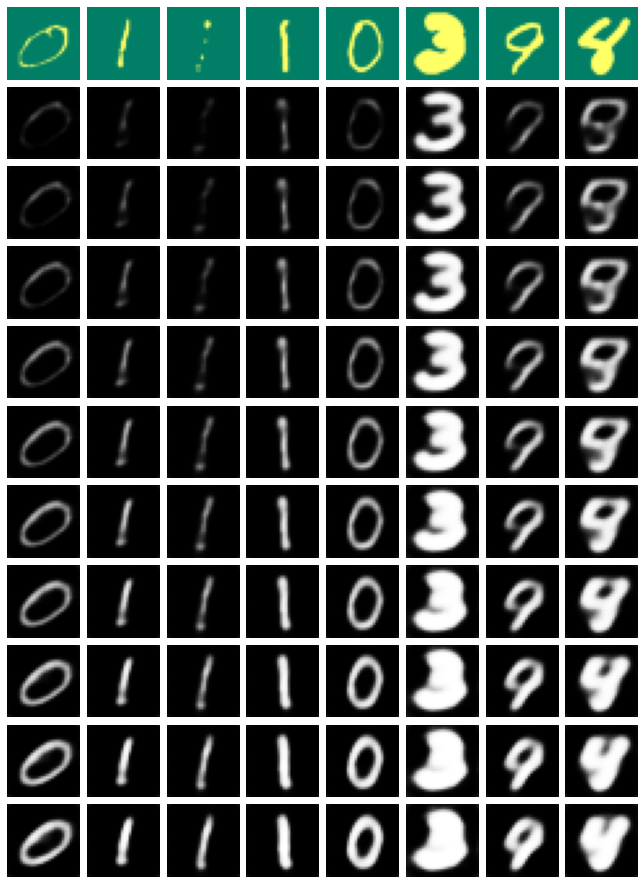

In [49]:
interpolate_and_display(model, 'thickness')

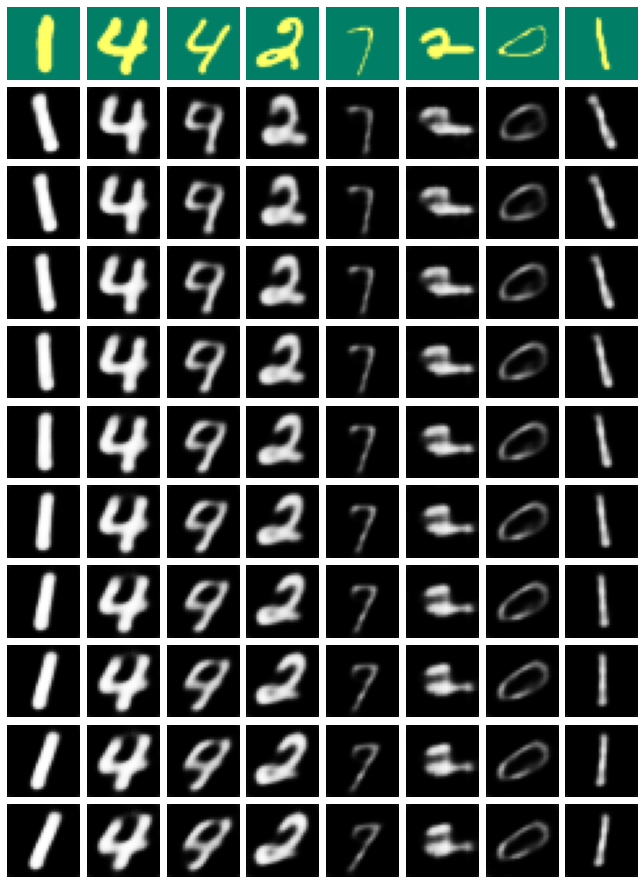

In [50]:
interpolate_and_display(model, 'slant')

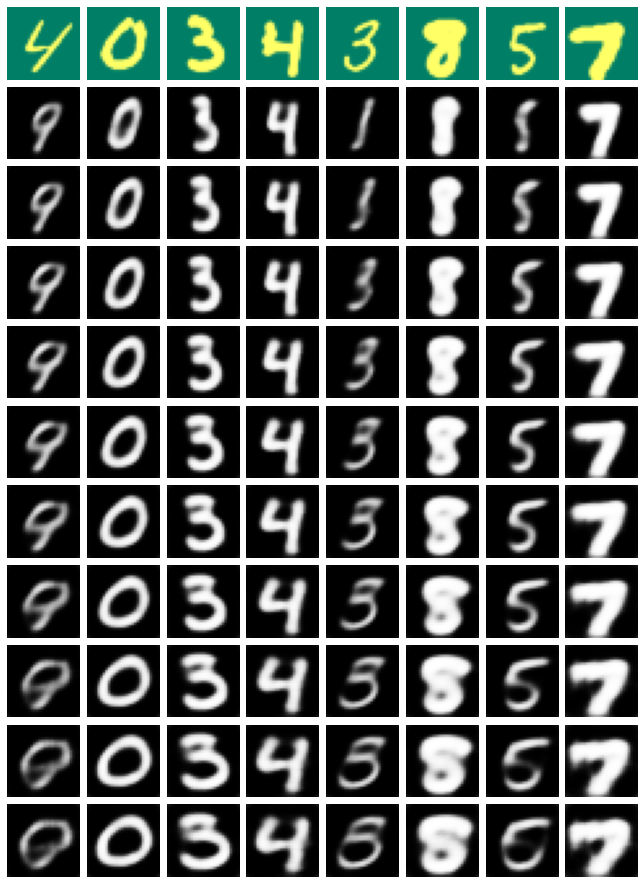

In [51]:
interpolate_and_display(model, 'width')